In [2]:
# Python 3.9. Anaconda recommended.
# -- Prerequisites install 
%pip install ipykernel --user
%pip install stable_baselines3 --user
%pip install tensorboard --user
%pip install torch --index-url https://download.pytorch.org/whl/cu117 --upgrade --force-reinstall --trusted-host pypi.org --trusted-host pytorch.org --trusted-host download.pytorch.org --no-cache --user


^C


# STABLEBASELINES TESTBED

In [26]:
# Battery env 
import gymnasium as gym
import numpy as np
from typing import Optional, Union
import itertools



#class BatteryEnv(gym.Env[np.ndarray, Union[int, np.ndarray]]):

class BatteryEnv(gym.Env):

   def __init__(self, nr_batteries, render_mode: Optional[str] = None):
      super().__init__()

      self.env_id = "Battery v0.4"
      self.num_envs = 1
      
      
      self.nr_batteries = nr_batteries


      self.soc_threshold_upper = 0.85
      self.soc_threshold_lower = 0.15


      self.action_space = gym.spaces.Box(-1, 1, (self.nr_batteries,), dtype=np.float32)       # current applied to cell1,cell2,cell3...
      self.observation_space = gym.spaces.Box(0, 1, (self.nr_batteries,), dtype=np.float32)   # SOCs for cell1, cell2, cell3...


      self.episode_time = 0
      self.state = None
      



   def step(self, action):
      err_msg = f"{action!r} ({type(action)}) invalid"
      assert self.action_space.contains(action), err_msg
      assert self.state is not None, "Call reset before using step method."


      battery_current_values = get_converted_action(action)


      self.episode_time += 1
      passed_threshold = False
      terminated = False
      truncated = False

      #Apply action to state
      self.state = np.subtract(self.state, battery_current_values)         

      for soc in self.state:

         if (soc < self.soc_threshold_lower or soc > self.soc_threshold_upper):
            passed_threshold = True
         if (soc < 0 or soc > 100):
            # Sanity check. Should never happen.
            soc = 0.0
            print("//////// EXITED OBSERVATION SPACE BOUNDS ////////  "  + str(soc))



      # Compute reward and termination cases
      reward = 0
      if not passed_threshold and self.episode_time == 128:
         # Apply step reward. Timeout.
         reward = compute_ballancing_reward(self.state, False)

         self.episode_time = 0
         truncated = True

      elif not passed_threshold:
         # Apply step reward. Continue running.
         reward = compute_ballancing_reward(self.state, False)

      
      elif passed_threshold:
         # Batteries drained! Terminated.
         reward = float(-100)
         terminated = True


      # Return modified
      return np.array(self.state, dtype=np.float32), float(reward), terminated, truncated, {}
   

       


   def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,):
        
         super().reset(seed=seed)



         self.episode_time = 0


         # Get random initial state for the episode.
         self.state = self.np_random.uniform(low=0.50, high=0.85, size=(self.nr_batteries,))


         return np.array(self.state, dtype=np.float32), {}



#CONVERT ACTION
   
def get_converted_action(action):
   current_values = []
   for current in action:
      shifted_value = ((current + 1.0) * 5.0)/100.0  #from [-1, 1] to [0, 0.1], to be reduced from SoC
      current_values.append(shifted_value)

   return current_values


# REWARD CALCULATION HELPERS 

def compute_closeness(socs):
   mean = 0
   for soc in socs:
      mean += soc
   mean = mean/len(socs)

   mean_diff = 0
   for  soc in socs:
      mean_diff += abs(mean - soc)

   mean_diff /= len(socs)

   min = np.array(socs).min()
   max = np.array(socs).max()
   abs_diff_min_max = max - min


   # alternative: (mean_diff_from_mean), or (mean_diff_from_mean*05 + abs_diff_min_max*0.5)
   return abs_diff_min_max

# Closeness function debug code
numbers = [0.6, 0.5, 0.8, 0.65, 0.85]
print(compute_closeness(numbers))
print(np.std(numbers, dtype=np.float32))  # standard deviation






# Get reward for a given step
def compute_ballancing_reward(socs, should_print):

   # ---- REWARD ALTERNATIVES ----

   # 1. Cost as distance between 2 numbers. Yang
   #reward = -pow(soc0 - soc1, 2)
      
   # 2. Cost as standard deviation
   # reward = -np.std(normalized_socs, dtype=np.float32)

   # ---- REWARD ALTERNATIVES ----


   

   reward = 0

   # Give 0.2 for each pair of SOCs that are within 0.02 distance of eachother.
   for i in range(len(socs)):
      for j in range(i + 1, len(socs)):
         if (math.isclose(socs[i], socs[j], abs_tol=0.02)):
            reward += 0.2
   
   # Introduce closeness to the reward
   reward = reward - compute_closeness(socs)
             
   return reward




0.35
0.12884098


# PLOTTING FUNCTIONS:

In [27]:
import matplotlib.pyplot as plt
from IPython import display



def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")


def plot_results(log_folder, title="Learning Curve"):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), "timesteps")
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y) :]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title(title + " Smoothed")
    # plt.show()

    display.clear_output(wait=True)
    display.display(plt.gcf())


In [28]:
import stable_baselines3
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback


import os
import torch
import math
import numpy as np
from typing import Optional, Union




class PlotResultsCallback(BaseCallback):

    def __init__(self, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.log_dir = log_dir
        self.save_path = None

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        plot_results(self.log_dir)

        return True
    
    



# Initialize environment

In [29]:
# !pip install gymnasium[box2d]
import gymnasium as gym
from stable_baselines3.common.env_checker import check_env


# Create log dir
log_dir = "./tmp/gym/pponormtest/"
os.makedirs(log_dir, exist_ok=True)


# Create and wrap the environment
env = BatteryEnv(4, False)

for i in range(0, 100):
    check_env(env)


# Logs will be saved in log_dir/monitor.csv 
env = Monitor(env, log_dir) #monitor for raw environments



# Opt1: Initialize a new model

In [30]:
from stable_baselines3 import A2C, SAC, PPO, TD3


print("Is CUDA enabled?", torch.cuda.is_available())



model = PPO('MlpPolicy', env, verbose=0, device="cuda", tensorboard_log="./pponorm_tensorboard_log/")



Is CUDA enabled? True


# Opt 2: Load existing trained model from save file

In [15]:
from stable_baselines3 import A2C, SAC, PPO, TD3

model = PPO.load(env=env, path=os.path.join(log_dir, "best_model_ppo_norm300"))

Train model for X timesteps.
Can be interrupted and retain training.

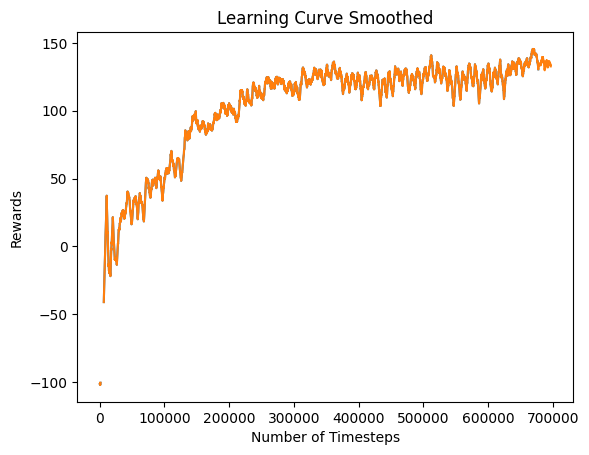

KeyboardInterrupt: 

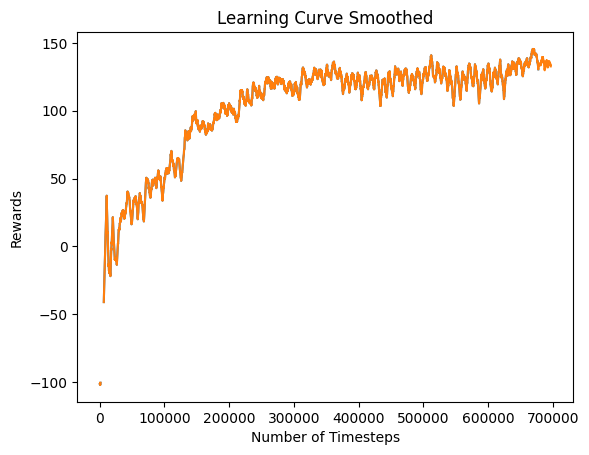

In [69]:
from stable_baselines3.common import results_plotter
from stable_baselines3 import A2C, SAC, PPO, TD3


callback = EvalCallback(env, log_path=log_dir, n_eval_episodes= 50, eval_freq= 25*128,
                            best_model_save_path=os.path.join(log_dir, "best_model_ppo_norm"),
                            callback_on_new_best=PlotResultsCallback(log_dir=log_dir))
# Eval callback, for plotting and seeing how the training is going, and saving best models. No effect on the results.

model.learn(total_timesteps=int(300000000000000), callback=callback)


# Plot helper from the library
results_plotter.plot_results(
    [log_dir], 1e7, results_plotter.X_TIMESTEPS, "PPO - Env: Battery"
)


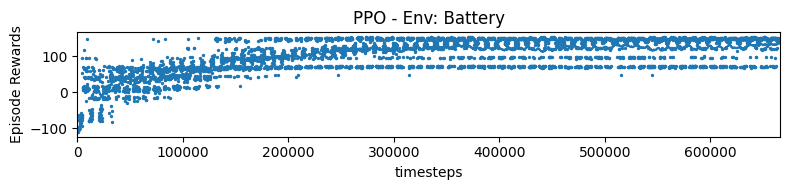

In [52]:
results_plotter.plot_results(
    [log_dir], 1e7, results_plotter.X_TIMESTEPS, "PPO - Env: Battery"
)

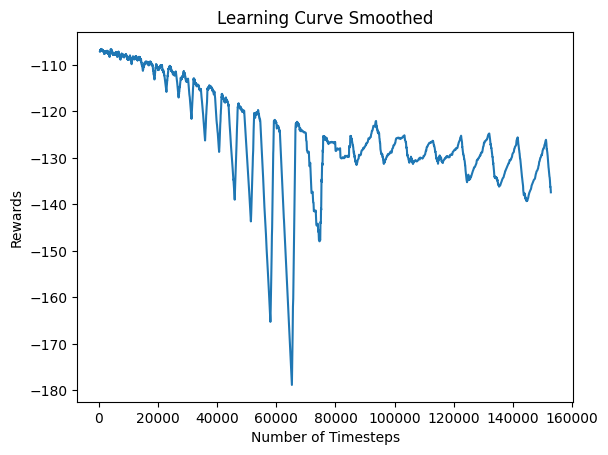

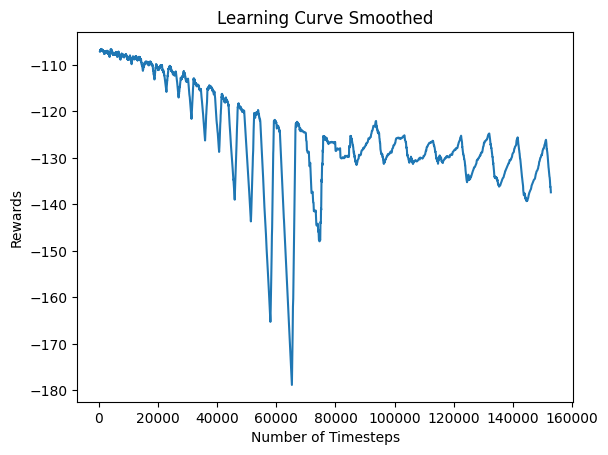

In [14]:

plot_results(log_dir)

# Test 1 episode of the model

[[0.64037085 0.5472442  0.58388174 0.8022491 ]]  ACTION:[0.01576063 0.         0.         0.1       ]  >>>> 
[[0.62461025 0.5472442  0.58388174 0.70224905]]  REWARD:  [-0.15500486]   
[[0.62461025 0.5472442  0.58388174 0.70224905]]  ACTION:[0.01741213 0.         0.         0.1       ]  >>>> 
[[0.6071981  0.5472442  0.58388174 0.602249  ]]  REWARD:  [0.34004608]   
[[0.6071981  0.5472442  0.58388174 0.602249  ]]  ACTION:[0.02205123 0.         0.         0.0246055 ]  >>>> 
[[0.5851469  0.5472442  0.58388174 0.5776436 ]]  REWARD:  [0.5620973]   
[[0.5851469  0.5472442  0.58388174 0.5776436 ]]  ACTION:[0.00546694 0.         0.         0.01744353]  >>>> 
[[0.57967997 0.5472442  0.58388174 0.56020004]]  REWARD:  [0.5633625]   
[[0.57967997 0.5472442  0.58388174 0.56020004]]  ACTION:[0.01346123 0.         0.01367003 0.        ]  >>>> 
[[0.56621873 0.5472442  0.5702117  0.56020004]]  REWARD:  [0.9770325]   
[[0.56621873 0.5472442  0.5702117  0.56020004]]  ACTION:[0.00490808 0.         0.017983

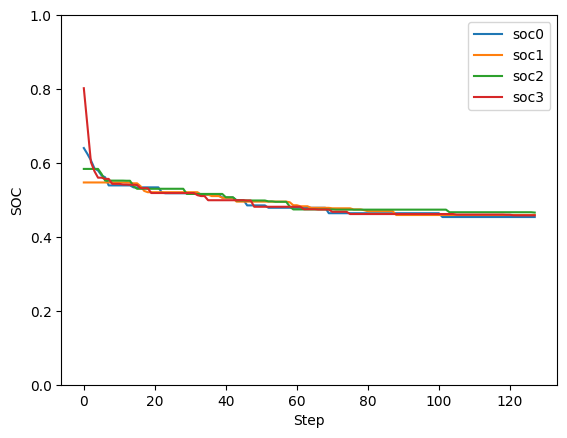

In [70]:

# model.save(os.path.join(log_dir, "best_model_ppo_rwd"))


def test_trained_model():
    obs = model.get_env().reset()
    episode_reward = 0

    obsArray = []

    while True:
        obsArray.append(obs)
        action, _states = model.predict(obs)
        oldObs = obs
        obs, rewards, done, info = model.get_env().step(action)
        episode_reward += rewards.squeeze()

        if not done:
            print(str(oldObs) + "  ACTION:" + str(get_converted_action(action)[0]) + "  >>>> ")
            print(str(obs) + "  REWARD:  "  + str(rewards) + "   ")
        else:
            info_item = info.pop()
            print("FINAL: ")
            print(str(info_item.get('terminal_observation'))  + "       ACTION:" )
            print(str(str(get_converted_action(action.flatten()))))
            print("REWARD:  " + str(rewards[0]))
            print("EPISODE TOTAL REWARD: " + str(episode_reward))

            # plot final model
            fig = plt.figure(1)

            data_np = np.array(obsArray)

            plt.xlabel('Step')
            plt.ylabel('SOC')
            print("------------------------------------------------------")
            plt.ylim([0, 1])


            i = 0
            for soc in data_np.T:
                plt.plot(np.arange(start=0, stop=len(data_np), step=1), soc.flatten(), label="soc"+str(i))
                i += 1

            plt.legend()
            #plt.pause(3)

            obsArray = []
            episode_reward = 0
            obs = model.get_env().reset()

            #time.sleep(0.5)
            break




test_trained_model()
